# Import libraries

In [85]:
import os
import sys
import datetime

from termcolor import colored, cprint

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
from os import listdir

import numpy as np
import pandas as pd  # Import Pandas and Numpy to create databases
import tensorflow as tf  # Import tensorflow to do tensor manipulations
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from chasm.glob import glob
scaler = StandardScaler()

In [86]:
phenotypes_labels = {
    "bc": "Breast Cancer",
    "cad": "Coronary Artery Disease",
    "ms": "Multiple Sclerosis",
    "t2d": "Type 2 Diabetes",
    "pc": "Prostate Cancer",
    "ibd": "Inflammatory Bowel Disease"
}

scenario_labels = {
    "no_cov": "no covariates",
    "abyss": "Abyss correction",
    "cov": "PCA correction",
    "abyss_cov": "Abyss + PCA as covariates"
}

# Load Sumstats

In [87]:
disease = "ms"
scenario = "abyss"
max_maf = 0.5
min_maf = 0
logp_min = 6
logp_max = 100
P_cutoff = 5e-8
PCs = 15
nr_snps = 10
bin =5

In [88]:
path_input = glob.PATH_GENO + f"/09_summary_statistics/{disease}/{scenario}"

In [89]:
list_of_bins = os.listdir(path_input)

In [90]:
list_of_dfs = []
for biny in list_of_bins[0:1]:
    biny = f"bin_{bin}_sumstat.pkl"
    try:
        temp = pd.read_pickle(path_input+f"/{biny}")
        temp['bin'] = biny.split('_')[1]
        
        # Sort by -logp in descending order and take the top 1000 SNPs
        top_snps = temp.sort_values(by='-logp', ascending=False).head(nr_snps)
        
        list_of_dfs.append(top_snps)
    except Exception as e:
        print(e)
        print(f"Problem with chrom {biny}")

# Concatenating the top SNPs from each bin
sumstat = pd.concat(list_of_dfs)

# Sorting by chromosome if needed
sumstat = sumstat.sort_values(by='#CHROM', ascending=True)

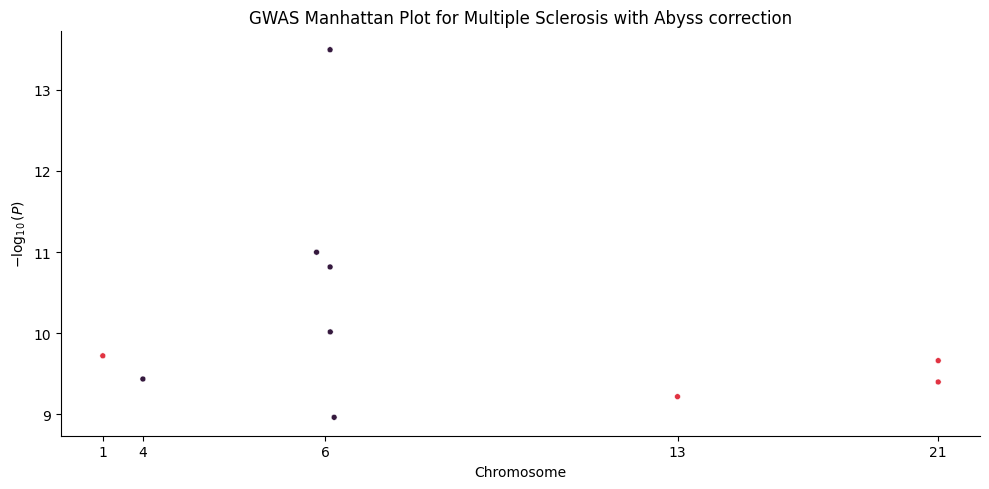

In [91]:
running_pos = 0
cumulative_pos = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    cumulative_pos.append(group_df['POS'] + running_pos)
    running_pos += group_df['POS'].max()

sumstat['cumulative_pos'] = pd.concat(cumulative_pos)
sumstat['SNP number'] = sumstat.index

# Define two contrasting colors from the rocket palette
palette = sns.color_palette("rocket", as_cmap=False)
color1 = palette[3]  # First color of the palette
color2 = palette[0] # Last color of the palette, for maximum contrast

# Function to assign color based on chromosome
def assign_color(chrom_number):
    return color1 if chrom_number % 2 == 0 else color2

# Apply the function to create a color column
sumstat['color'] = sumstat['#CHROM'].apply(assign_color)

chrom_midpoints = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    midpoint = group_df['cumulative_pos'].min() + (group_df['cumulative_pos'].max() - group_df['cumulative_pos'].min()) / 2
    chrom_midpoints.append(midpoint)

# Plotting
g = sns.relplot(
    data=sumstat,
    x='cumulative_pos',
    y='-logp',
    aspect=2,
    hue='color',
    palette=[color1, color2],
    legend=False,
    size=3 
)


# Set x-axis ticks and labels with reversed chromosome order
chrom_labels = np.sort(sumstat['#CHROM'].unique()) # Reversing the order of chromosomes

# Set the title and x-axis, y-axis labels
g.set(title=f"GWAS Manhattan Plot for {phenotypes_labels[disease]} with {scenario_labels[scenario]}")
g.set(xticks=chrom_midpoints, xticklabels=chrom_labels)
g.set_axis_labels("Chromosome", r"$-\log_{10}(P)$")  # Set y-axis label with subscript

# Set the tick labels at a 45-degree angle
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Optional: Improve the layout
plt.tight_layout()
plt.show()

# Find geno and mafs for selected SNPs

In [92]:
sumstat

,snp,consts,beta_snp,beta_maf,std_err,Z,P,#CHROM,POS,-logp,bin,cumulative_pos,SNP number,color
41309,1:113214413:C_T_C,-1.118725,0.040691,1.731817,0.010121,4.020333,0.000060,1,113214413,9.722245,5,113214413,41309,"(0.20973515, 0.09747934, 0.24238489)"
32657,4:6885815:C_T_T,3.642388,-0.041096,-3.423610,0.010399,-3.952021,0.000080,4,6885815,9.436416,5,120100228,32657,"(0.8833417, 0.19830556, 0.26014181)"
34592,6:32151443:C_T_C,-5.551285,0.052742,6.499583,0.010897,4.840267,0.000001,6,32151443,13.493237,5,152251671,34592,"(0.8833417, 0.19830556, 0.26014181)"
28045,6:29829566:G_T_T,0.074825,0.046600,0.455121,0.010803,4.313520,0.000017,6,29829566,10.998460,5,149929794,28045,"(0.8833417, 0.19830556, 0.26014181)"
28498,6:32157364:A_G_G,2.684197,0.047892,-2.326410,0.011208,4.272900,0.000020,6,32157364,10.816849,5,152257592,28498,"(0.8833417, 0.19830556, 0.26014181)"
31096,6:32185605:A_G_G,8.332479,0.045640,-8.388968,0.011160,4.089675,0.000045,6,32185605,10.016835,5,152285833,31096,"(0.8833417, 0.19830556, 0.26014181)"
19679,6:32853219:C_T_T,6.217382,0.042405,-6.210982,0.011052,3.836788,0.000128,6,32853219,8.964122,5,152953447,19679,"(0.8833417, 0.19830556, 0.26014181)"
11467,13:58981163:A_G_G,-1.833237,0.040601,2.524250,0.010412,3.899334,0.000099,13,58981163,9.218937,5,211934610,11467,"(0.20973515, 0.09747934, 0.24238489)"
29846,21:44784639:C_T_C,-1.431127,0.043364,2.096315,0.010824,4.006220,0.000064,21,44784639,9.662835,5,256719249,29846,"(0.20973515, 0.09747934, 0.24238489)"
14545,21:44784750:A_G_A,-1.419726,0.042682,2.055758,0.010824,3.943233,0.000083,21,44784750,9.399963,5,256719360,14545,"(0.20973515, 0.09747934, 0.24238489)"


In [93]:
unique_bins = list(sumstat['bin'].unique())

In [122]:
genos = []
mafs = []

# Iterate over unique bins
for unique_bin in unique_bins:
    # Filter sumstat for the current bin
    temp_sumstat = sumstat[sumstat['bin'] == unique_bin]

    # Construct path for genotype mapping
    path_geno_mapping = os.path.join(glob.PATH_GENO, f"04_LD_blocks/{PCs}_PCs/bin_{unique_bin}")
    
    # Load mapping data
    map_file = os.path.join(path_geno_mapping, "mapping.pkl")
    map = pd.read_pickle(map_file)
    map.rename(columns={'Position': 'POS'}, inplace=True)
    map['POS'] = map['POS'].astype(int)

    # Get path for MAF dimensions
    path_dims_of_maf = os.path.join(glob.PATH_GENO, f"08_MAF_probability_landscape/{disease}/bin_{unique_bin}")
    dims_of_maf = os.listdir(path_dims_of_maf)[0]
    path_maf = os.path.join(path_dims_of_maf, dims_of_maf)

    # Merge sumstat with mapping data
    temp_sumstat = pd.merge(temp_sumstat, map[['POS','Chromosome','Alls2', 'path']], on='POS', how='inner')
    
    # Process each unique path
    unique_paths = temp_sumstat['path'].unique()
    for path in unique_paths:
        temp2_sumstat = temp_sumstat[temp_sumstat['path'] == path]
        SNPS = temp2_sumstat['snp'].tolist()
        for snp in SNPS:
            # Find the file with SNP data and load genotypes
            file_with_snp = next(f for f in os.listdir(path_geno_mapping) if f.startswith(path))
            path_file_genos = os.path.join(path_geno_mapping, file_with_snp)
            geno = pd.read_pickle(path_file_genos)[[snp]]
            geno[f"{snp}_P_val"] = list(temp2_sumstat['-logp'])[0]
            genos.append(geno)
    
            # Load MAF data
            path_file_maf = os.path.join(path_maf, file_with_snp)
            maf = pd.read_pickle(path_file_maf)[[snp]]
            maf[f"{snp}_P_val"] = list(temp2_sumstat['-logp'])[0]
            mafs.append(maf)

In [123]:
combined_geno = pd.concat(genos, axis=1)

In [124]:
combined_maf = pd.concat(mafs, axis=1)

In [125]:
combined_geno

,1:113214413:C_T_C,1:113214413:C_T_C_P_val,4:6885815:C_T_T,4:6885815:C_T_T_P_val,6:32151443:C_T_C,6:32151443:C_T_C_P_val,6:29829566:G_T_T,6:29829566:G_T_T_P_val,6:32157364:A_G_G,6:32157364:A_G_G_P_val,6:32185605:A_G_G,6:32185605:A_G_G_P_val,6:32853219:C_T_T,6:32853219:C_T_T_P_val,13:58981163:A_G_G,13:58981163:A_G_G_P_val,21:44784639:C_T_C,21:44784639:C_T_C_P_val,21:44784750:A_G_A,21:44784750:A_G_A_P_val
0,1,9.722245,0,9.436416,1,13.493237,0,10.99846,1,10.816849,1,10.016835,1,8.964122,1,9.218937,0,9.662835,0,9.399963
1,1,9.722245,1,9.436416,1,13.493237,1,10.99846,1,10.816849,1,10.016835,1,8.964122,1,9.218937,1,9.662835,1,9.399963
2,1,9.722245,1,9.436416,1,13.493237,1,10.99846,1,10.816849,1,10.016835,1,8.964122,1,9.218937,0,9.662835,0,9.399963
3,1,9.722245,1,9.436416,1,13.493237,1,10.99846,1,10.816849,1,10.016835,1,8.964122,1,9.218937,1,9.662835,1,9.399963
4,1,9.722245,1,9.436416,1,13.493237,1,10.99846,1,10.816849,1,10.016835,1,8.964122,1,9.218937,1,9.662835,1,9.399963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69450,1,9.722245,1,9.436416,1,13.493237,1,10.99846,1,10.816849,1,10.016835,1,8.964122,1,9.218937,1,9.662835,1,9.399963
69451,1,9.722245,1,9.436416,1,13.493237,1,10.99846,1,10.816849,1,10.016835,1,8.964122,1,9.218937,1,9.662835,1,9.399963
69452,1,9.722245,1,9.436416,1,13.493237,1,10.99846,1,10.816849,1,10.016835,1,8.964122,1,9.218937,1,9.662835,1,9.399963
69453,1,9.722245,0,9.436416,1,13.493237,1,10.99846,1,10.816849,1,10.016835,1,8.964122,1,9.218937,1,9.662835,1,9.399963


In [126]:
# Extract chromosome numbers and group columns
chromosome_to_columns = {}
for col in combined_geno.columns:
    chromosome = col.split(':')[0]
    if chromosome not in chromosome_to_columns:
        chromosome_to_columns[chromosome] = []
    chromosome_to_columns[chromosome].append(col)

# Split into separate DataFrames based on chromosome
chromosome_dfs = {}
for chromosome, cols in chromosome_to_columns.items():
    chromosome_dfs[chromosome] = combined_geno[cols]

In [127]:
# Split into separate DataFrames based on chromosome
chromosome_maf_dfs = {}
for chromosome, cols in chromosome_to_columns.items():
    chromosome_maf_dfs[chromosome] = combined_maf[cols]

# Order in LD blocks

In [128]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from k_means_constrained import KMeansConstrained
from abyss.glob import glob
import random
from math import floor
from collections import Counter

In [129]:
chromosome_dfs

{'1':        1:113214413:C_T_C  1:113214413:C_T_C_P_val
 0                      1                 9.722245
 1                      1                 9.722245
 2                      1                 9.722245
 3                      1                 9.722245
 4                      1                 9.722245
 ...                  ...                      ...
 69450                  1                 9.722245
 69451                  1                 9.722245
 69452                  1                 9.722245
 69453                  1                 9.722245
 69454                  1                 9.722245
 
 [69455 rows x 2 columns],
 '4':        4:6885815:C_T_T  4:6885815:C_T_T_P_val
 0                    0               9.436416
 1                    1               9.436416
 2                    1               9.436416
 3                    1               9.436416
 4                    1               9.436416
 ...                ...                    ...
 69450              

In [130]:
snp_ids = []
chroms = []
labels = []
PC1s = []
PC2s = []
for chrom_key in chromosome_dfs.keys():
    genos = chromosome_dfs[chrom_key].T
    nr_snps_in_genos = genos.shape[0]
    
    num_clus = 3
    n_components = 5
    if nr_snps_in_genos > num_clus:
        sample_size = np.round(nr_snps_in_genos//num_clus)
        size_min = sample_size - round(sample_size / 5)
        size_max = (sample_size + round(sample_size / 5))+1
        # Standardize the data
        #scaler = StandardScaler()
        #df_scaled = scaler.fit_transform(genos)
        
        # Perform PCA with n components
        pca = PCA(n_components=n_components)
        #principal_components = pca.fit_transform(df_scaled)
        principal_components = pca.fit_transform(genos)
        # Create a new DataFrame to store the principal components
        pc_columns = [f'PC{i+1}' for i in range(n_components)]
        df_pca = pd.DataFrame(data=principal_components, columns=pc_columns)
        
        # Apply constrained K-Means clustering
        clf = KMeansConstrained(
            n_clusters=num_clus,
            size_min=size_min,
            size_max=size_max,
            random_state=0
        )
        clf.fit_predict(np.array(df_pca))
        
        # Assign cluster labels to genotypic data
        count = Counter(clf.labels_)
        genos['clusters'] = clf.labels_
    else:
        #scaler = StandardScaler()
        #df_scaled = scaler.fit_transform(genos)
        
        # Perform PCA with n components
        pca = PCA(n_components=n_components)
        #principal_components = pca.fit_transform(df_scaled)
        principal_components = pca.fit_transform(genos)
        pc_columns = [f'PC{i+1}' for i in range(n_components)]
        df_pca = pd.DataFrame(data=principal_components, columns=pc_columns)
        genos['clusters'] = 0
    # Reindex both DataFrames based on row order
    temp = genos.reset_index(drop=True)
    df_pca = df_pca.reset_index(drop=True)
    
    # Concatenate them again
    merged_df = pd.concat([temp, df_pca[pc_columns]], axis=1)
    
    # Set the index of merged_df to match the index of genos
    merged_df.index = genos.index
    genos = merged_df
    for num in genos.clusters.unique():
        to_save = genos.loc[genos['clusters'] == num]
        to_save_snps = to_save.drop(columns=['clusters']+pc_columns).T
        to_save_PCs = to_save[pc_columns].T
        for snp_id in to_save_snps:
            snp_ids.append(snp_id)
            chroms.append(chrom_key)
            labels.append(f"{chrom_key}_{num}")
            PC1s.append(to_save_PCs.loc['PC1'][snp_id])
            try:
                PC2s.append(to_save_PCs.loc['PC2'][snp_id])
            except:
                PC2s.append(0)
            

ValueError: n_components=5 must be between 0 and min(n_samples, n_features)=2 with svd_solver='full'

In [55]:
data = {
    'snp': snp_ids,
    'chroms': chroms,
    'labels': labels,
    'PC1': PC1s,
    'PC2': PC2s
}
df = pd.DataFrame(data)

In [56]:
df

,snp,chroms,labels,PC1,PC2
0,1:57657301:C_T_C,1,1_2,-1.438122,-3.149559e-08
1,1:240361446:A_G_A,1,1_2,-2.274152,-3.579323e-08
2,1:225880082:A_G_A,1,1_2,-1.570544,-1.578101e-08
3,1:55712080:A_G_A,1,1_2,-2.611845,1.062037e-07
4,1:113214413:C_T_C,1,1_2,-2.720445,4.190635e-08
...,...,...,...,...,...
995,7:44695725:C_T_T,7,7_0,2.265068,4.064297e-08
996,7:116322791:A_C_A,7,7_0,2.364878,-5.839271e-08
997,7:116323936:G_T_G,7,7_0,2.002875,1.043454e-07
998,7:31827417:A_G_A,7,7_0,1.836905,8.240711e-08


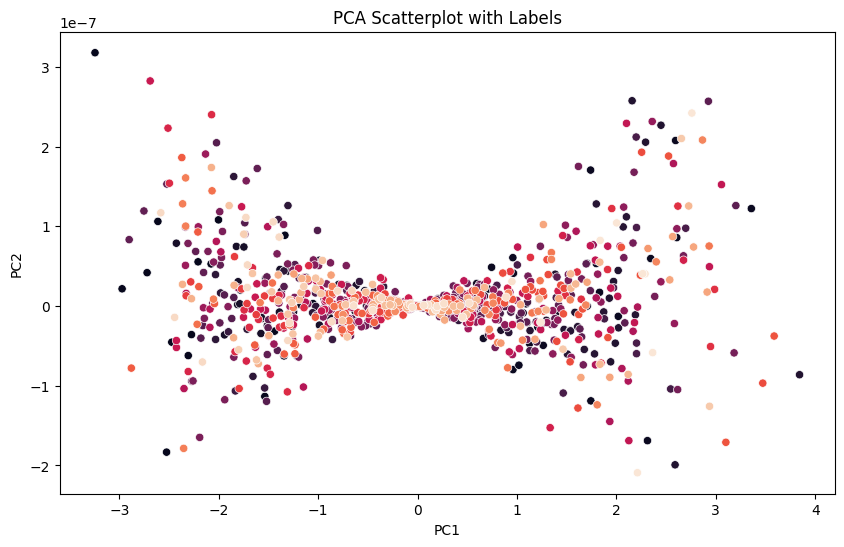

In [57]:
# Create a seaborn scatterplot

plt.figure(figsize=(10, 6))

scatter = sns.scatterplot(x='PC1', y='PC2', hue='labels', palette='rocket', data=df, legend= False)



# Enhancing the plot

scatter.set_title('PCA Scatterplot with Labels')


plt.show()

In [58]:
temp_sumstat = pd.merge(temp_sumstat, df, on='snp', how='inner')

In [59]:
temp_sumstat

,snp,consts,beta_snp,beta_maf,std_err,Z,P,#CHROM,POS,-logp,...,PC1_x,PC2_x,chroms_y,labels_y,PC1_y,PC2_y,chroms,labels,PC1,PC2
0,1:57657301:C_T_C,-25.364974,-0.028161,27.554107,0.009761,-2.884951,0.003950,1,57657301,5.533993,...,-242.124405,-3.181419e-06,1,1_2,-1.438122,-3.149559e-08,1,1_2,-1.438122,-3.149559e-08
1,1:240361446:A_G_A,-5.103563,0.027380,6.049136,0.010306,2.656641,0.007945,1,240361446,4.835163,...,-382.881073,-7.322027e-07,1,1_2,-2.274152,-3.579323e-08,1,1_2,-2.274152,-3.579323e-08
2,1:225880082:A_G_A,6.121640,-0.029894,-6.004777,0.010832,-2.759885,0.005827,1,225880082,5.145296,...,-264.419922,-3.051233e-06,1,1_2,-1.570544,-1.578101e-08,1,1_2,-1.570544,-1.578101e-08
3,1:55712080:A_G_A,-5.174568,-0.026032,6.069877,0.010256,-2.538130,0.011208,1,55712080,4.491100,...,-439.737518,-1.158118e-05,1,1_2,-2.611845,1.062037e-07,1,1_2,-2.611845,1.062037e-07
4,1:97353641:C_T_T,-1.809774,0.025734,2.498658,0.010136,2.538891,0.011184,1,97353641,4.493269,...,155.099640,-2.689779e-06,1,1_0,0.921218,1.337901e-08,1,1_0,0.921218,1.337901e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,22:19984200:C_T_C,-8.371158,0.032120,9.414302,0.010219,3.143292,0.001691,22,19984200,6.382260,...,544.736633,9.531496e-06,22,22_0,2.318226,7.220068e-08,22,22_0,2.318226,7.220068e-08
996,22:23723050:A_G_A,9.846214,0.025415,-10.032593,0.010363,2.452461,0.014260,22,23723050,4.250293,...,196.889725,-5.000788e-06,22,22_0,0.837904,-4.642789e-08,22,22_0,0.837904,-4.642789e-08
997,22:18590899:A_C_C,-2.170864,0.026922,2.880135,0.010474,2.570382,0.010219,22,18590899,4.583474,...,-16.480482,7.997645e-07,22,22_2,-0.070138,3.174578e-09,22,22_2,-0.070138,3.174578e-09
998,22:35390846:A_G_G,-6.646281,0.026724,7.736797,0.010828,2.468015,0.013657,22,35390846,4.293520,...,-292.345001,1.025131e-05,22,22_1,-1.244135,4.021498e-08,22,22_1,-1.244135,4.021498e-08


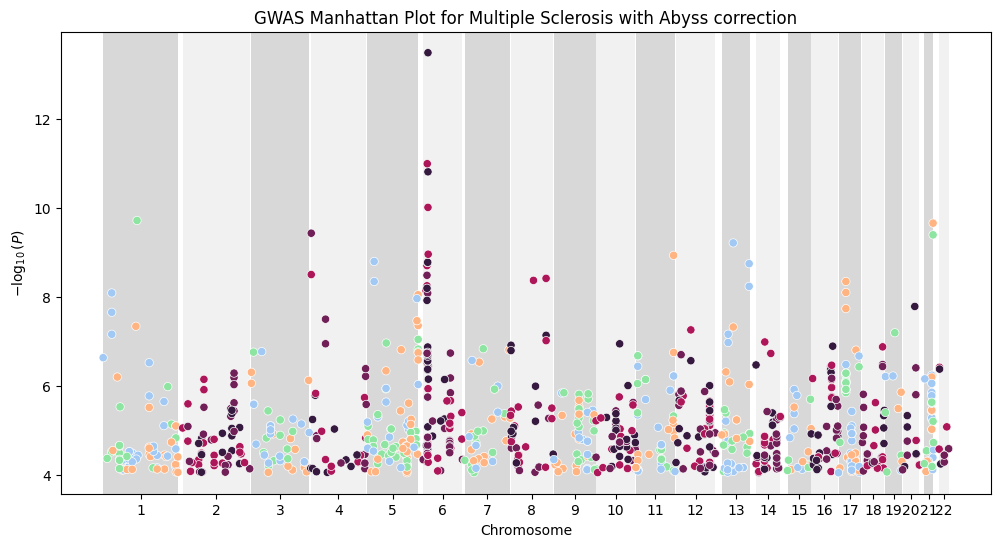

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define two palettes

even_palette = sns.color_palette("rocket")  # Lighter palette for even chromosomes
odd_palette = sns.color_palette("pastel")     # Darker palette for odd chromosomes

# Define background colors for segments
bg_color_even = "lightgrey"  # Background color for even segments
bg_color_odd = "grey"        # Background color for odd segments

# Create a figure for the Manhattan plot
plt.figure(figsize=(12, 6))

# Get start, end positions and midpoints for each chromosome
chromosomes = temp_sumstat['#CHROM'].unique()
chrom_midpoints = []
start_end_positions = []
for chrom in chromosomes:
    start = temp_sumstat[temp_sumstat['#CHROM'] == chrom]['cumulative_pos'].min()
    end = temp_sumstat[temp_sumstat['#CHROM'] == chrom]['cumulative_pos'].max()
    midpoints = (start + end) / 2
    chrom_midpoints.append(midpoints)
    start_end_positions.append((start, end))

# Add a background color for each chromosome segment
for i, (start, end) in enumerate(start_end_positions):
    chrom = chromosomes[i]
    plt.axvspan(start, end, facecolor=bg_color_even if chrom % 2 == 0 else bg_color_odd, alpha=0.3)

# Plot the data
sns.scatterplot(
    data=temp_sumstat,
    x='cumulative_pos',
    y='-logp',
    hue='labels',
    palette={label: (even_palette if int(label.split('_')[0]) % 2 == 0 else odd_palette)[int(label.split('_')[1]) % len(even_palette)] for label in temp_sumstat['labels'].unique()},
    legend=False
)

# Set title and axis labels
plt.title(f"GWAS Manhattan Plot for {phenotypes_labels[disease]} with {scenario_labels[scenario]}")
plt.xlabel("Chromosome")
plt.ylabel(r"$-\log_{10}(P)$")

# Set x-axis ticks and labels with reversed chromosome order
chrom_labels = np.sort(chromosomes)  # Reversing the order of chromosomes
plt.xticks(chrom_midpoints, chrom_labels)

# Set the tick labels at a 45-degree angle
plt.xticks(rotation=0)

# Show the plot
plt.show()
